# Libraries and PySpark Session

In [2]:
pip install spark-nlp==3.3.4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy pandas nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession

In [2]:
SparkSession.builder.appName("BDA_Reddit_Preprocessing").getOrCreate()

In [3]:
from sparknlp.annotator import LemmatizerModel
import pyspark.sql.functions as f
from pyspark.sql import Window
import pyspark.sql.types as t
from pyspark.ml.feature import Tokenizer as pysparkTokenizer, HashingTF, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, Normalizer, LemmatizerModel, StopWordsCleaner, PerceptronModel, Chunker
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bda_reddit_pw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Tests

In [4]:
# Whole data or just a single batch?

df = spark.read.json("stream_reddit/97410eb3-*.json").distinct()
# df = spark.read.json("stream_reddit/*.json").distinct()

In [5]:
df.printSchema()

root
 |-- comments: long (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- text: string (nullable = true)
 |-- time: double (nullable = true)
 |-- title: string (nullable = true)
 |-- upvotes: long (nullable = true)



In [12]:
df = df.select("id", "subreddit", "title", "text", "time")

Concatenating text

In [13]:
df = df.select("id", "time", "subreddit", f.concat_ws(" ", df.title, df.text).alias("text"))

In [14]:
df.count()

2538

## NLP-related tasks

In [11]:
from sparknlp.annotator import Lemmatizer, Stemmer, Tokenizer, Normalizer
from sparknlp.base import DocumentAssembler, Finisher

In [12]:
# Spark Pipelines allow us to sequentially add components such as transformers
from pyspark.ml import Pipeline

# These are components we will incorporate into our pipeline.
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF

In [13]:
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

In [14]:
# # https://towardsdatascience.com/natural-language-processing-with-pyspark-and-spark-nlp-b5b29f8faba

# documentAssembler = DocumentAssembler() \
#      .setInputCol('text') \
#      .setOutputCol('document')
# tokenizer = Tokenizer() \
#      .setInputCols(['document']) \
#      .setOutputCol('token')
# # note normalizer defaults to changing all words to lowercase.
# # Use .setLowercase(False) to maintain input case.
# normalizer = Normalizer() \
#      .setInputCols(['token']) \
#      .setOutputCol('normalized') \
#      .setLowercase(True)
# # note that lemmatizer needs a dictionary. So I used the pre-trained
# # model (note that it defaults to english)
# lemmatizer = LemmatizerModel.pretrained() \
#      .setInputCols(['normalized']) \
#      .setOutputCol('lemma')
# stopwords_cleaner = StopWordsCleaner() \
#      .setInputCols(['lemma']) \
#      .setOutputCol('clean_lemma') \
#      .setCaseSensitive(False) \
#      .setStopWords(eng_stopwords)
# # finisher converts tokens to human-readable output
# finisher = Finisher() \
#      .setInputCols(['clean_lemma']) \
#      .setCleanAnnotations(False)

In [15]:
# pipeline = Pipeline() \
#      .setStages([
#            documentAssembler,
#            tokenizer,
#            normalizer,
#            lemmatizer,
#            stopwords_cleaner,
#            finisher
#      ])

In [16]:
# # https://codelabs.developers.google.com/codelabs/spark-nlp#7

# Now, we begin assembling our pipeline. Each component here is used to some transformation to the data.
# The Document Assembler takes the raw text data and convert it into a format that can
# be tokenized. It becomes one of spark-nlp native object types, the "Document".
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

# The Tokenizer takes data that is of the "Document" type and tokenizes it.
# While slightly more involved than this, this is effectively taking a string and splitting
# it along ths spaces, so each word is its own string. The data then becomes the
# spark-nlp native type "Token".
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

# The Normalizer will group words together based on similar semantic meaning.
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalizer")

# The Stemmer takes objects of class "Token" and converts the words into their
# root meaning. For instance, the words "cars", "cars'" and "car's" would all be replaced
# with the word "car".
stemmer = Stemmer().setInputCols(["normalizer"]).setOutputCol("stem")

# The Finisher signals to spark-nlp allows us to access the data outside of spark-nlp
# components. For instance, we can now feed the data into components from Spark MLlib.
finisher = Finisher().setInputCols(["stem"]).setOutputCols(["to_spark"]).setValueSplitSymbol(" ")

# Stopwords are common words that generally don't add much detail to the meaning
# of a body of text. In English, these are mostly "articles" such as the words "the"
# and "of".
stopword_remover = StopWordsRemover(inputCol="to_spark", outputCol="filtered")

# Here we implement TF-IDF as an input to our LDA model. CountVectorizer (TF) keeps track
# of the vocabulary that's being created so we can map our topics back to their
# corresponding words.
# TF (term frequency) creates a matrix that counts how many times each word in the
# vocabulary appears in each body of text. This then gives each word a weight based
# on its frequency.
tf = CountVectorizer(inputCol="filtered", outputCol="raw_features")

# Here we implement the IDF portion. IDF (Inverse document frequency) reduces
# the weights of commonly-appearing words.
idf = IDF(inputCol="raw_features", outputCol="features")

In [17]:
lda = LDA(k=10, maxIter=10)

# We add all of the transformers into a Pipeline object. Each transformer
# will execute in the ordered provided to the "stages" parameter
pipeline = Pipeline(
    stages = [
        document_assembler,
        tokenizer,
        normalizer,
        stemmer,
        finisher,
        stopword_remover,
        tf,
        idf,
        lda
    ]
)

In [18]:
text = df.select("text").fillna("")

In [19]:
model = pipeline.fit(text)

22/12/30 16:12:17 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 3.0 in stage 11.0 (TID 217) (bda-hdfs-dataproc-new-w-1.europe-north1-b.c.crypto-busting.internal executor 1): java.lang.ClassCastException: cannot assign instance of java.lang.invoke.SerializedLambda to field org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable.accessor of type scala.Function2 in instance of org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable
	at java.io.ObjectStreamClass$FieldReflector.setObjFieldValues(ObjectStreamClass.java:2301)
	at java.io.ObjectStreamClass.setObjFieldValues(ObjectStreamClass.java:1431)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2437)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.ja

Py4JJavaError: An error occurred while calling o107.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 11.0 failed 4 times, most recent failure: Lost task 3.3 in stage 11.0 (TID 224) (bda-hdfs-dataproc-new-w-0.europe-north1-b.c.crypto-busting.internal executor 3): java.lang.ClassCastException: cannot assign instance of java.lang.invoke.SerializedLambda to field org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable.accessor of type scala.Function2 in instance of org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable
	at java.io.ObjectStreamClass$FieldReflector.setObjFieldValues(ObjectStreamClass.java:2301)
	at java.io.ObjectStreamClass.setObjFieldValues(ObjectStreamClass.java:1431)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2437)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:76)
	at org.apache.spark.serializer.JavaSerializerInstance.deserialize(JavaSerializer.scala:115)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:85)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2225)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2244)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2269)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1253)
	at org.apache.spark.ml.feature.CountVectorizer.fit(CountVectorizer.scala:233)
	at org.apache.spark.ml.feature.CountVectorizer.fit(CountVectorizer.scala:149)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassCastException: cannot assign instance of java.lang.invoke.SerializedLambda to field org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable.accessor of type scala.Function2 in instance of org.apache.spark.sql.catalyst.expressions.objects.LambdaVariable
	at java.io.ObjectStreamClass$FieldReflector.setObjFieldValues(ObjectStreamClass.java:2301)
	at java.io.ObjectStreamClass.setObjFieldValues(ObjectStreamClass.java:1431)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2437)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:2119)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1657)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:527)
	at sun.reflect.GeneratedMethodAccessor6.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1184)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2322)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2431)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2355)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2213)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1669)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:503)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:461)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:76)
	at org.apache.spark.serializer.JavaSerializerInstance.deserialize(JavaSerializer.scala:115)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:85)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
from pyspark.sql.functions import explode, col
words = text.withColumn('exploded_text', 
                               explode(col('clean_lemma')))

In [ ]:
counts = words.groupby('exploded_text').count()
counts_pd = counts.toPandas()
equifax_dict = {counts_pd.loc[i, 'exploded_text']: 
                counts_pd.loc[i, 'count'] 
                for i in range(counts_pd.shape[0])}

## crypto stream

Unfortunately, too many JSONs just refuse to be loaded.

In [4]:
df = spark.read.json("stream_crypto").distinct()

In [5]:
df.printSchema()

root
 |-- price: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- side: string (nullable = true)
 |-- time: string (nullable = true)



In [6]:
df.count()

3486

In [7]:
df = df.select("product_id", "time", df.price.cast(t.DoubleType()))

In [8]:
df.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- time: string (nullable = true)
 |-- price: double (nullable = true)



In [9]:
import matplotlib.pyplot as plt

In [10]:
data = df.select("product_id", df.time.cast(t.TimestampType()), "price").collect()
data

[Row(product_id='DOGE-USD', time=datetime.datetime(2023, 1, 2, 8, 51, 53, 587139), price=0.07201),
 Row(product_id='DOGE-USD', time=datetime.datetime(2023, 1, 2, 6, 1, 47, 522377), price=0.07014),
 Row(product_id='BTC-USD', time=datetime.datetime(2023, 1, 2, 2, 1, 56, 515936), price=16552.34),
 Row(product_id='BTC-USD', time=datetime.datetime(2023, 1, 2, 7, 46, 57, 298398), price=16718.61),
 Row(product_id='BTC-USD', time=datetime.datetime(2023, 1, 2, 1, 53, 55, 300938), price=16563.78),
 Row(product_id='BTC-USD', time=datetime.datetime(2023, 1, 2, 7, 29, 57, 177138), price=16726.03),
 Row(product_id='DOGE-USD', time=datetime.datetime(2023, 1, 2, 2, 15, 52, 738022), price=0.06937),
 Row(product_id='DOGE-USD', time=datetime.datetime(2023, 1, 2, 0, 23, 51, 989186), price=0.06993),
 Row(product_id='BTC-USD', time=datetime.datetime(2023, 1, 2, 3, 46, 52, 520584), price=16604.36),
 Row(product_id='BTC-USD', time=datetime.datetime(2023, 1, 2, 6, 27, 56, 104297), price=16642.61),
 Row(product

In [11]:
product_id = [row.product_id for row in data]
plot_data = []
for product in set(product_id):
    plot_data.append({
        "product_id": product,
        "time": [row.time for row in data if row.product_id == product],
        "price": [row.price for row in data if row.product_id == product]
    })
plot_data

[{'product_id': 'SOL-USD',
  'time': [datetime.datetime(2023, 1, 2, 7, 22, 55, 493122),
   datetime.datetime(2023, 1, 2, 7, 29, 56, 157637),
   datetime.datetime(2023, 1, 2, 6, 26, 39, 984474),
   datetime.datetime(2023, 1, 2, 1, 30, 44, 352106),
   datetime.datetime(2023, 1, 2, 4, 36, 46, 376020),
   datetime.datetime(2023, 1, 2, 6, 38, 28, 550831),
   datetime.datetime(2023, 1, 2, 1, 42, 48, 386035),
   datetime.datetime(2023, 1, 2, 3, 33, 56, 240933),
   datetime.datetime(2023, 1, 2, 1, 29, 56, 457187),
   datetime.datetime(2023, 1, 2, 1, 53, 40, 261875),
   datetime.datetime(2023, 1, 2, 1, 10, 52, 678542),
   datetime.datetime(2023, 1, 2, 4, 30, 56, 733245),
   datetime.datetime(2023, 1, 2, 3, 36, 46, 322377),
   datetime.datetime(2023, 1, 2, 6, 51, 52, 174045),
   datetime.datetime(2023, 1, 2, 2, 17, 46, 287352),
   datetime.datetime(2023, 1, 2, 2, 50, 42, 269525),
   datetime.datetime(2023, 1, 2, 5, 46, 56, 864977),
   datetime.datetime(2023, 1, 2, 6, 55, 53, 767761),
   datetime

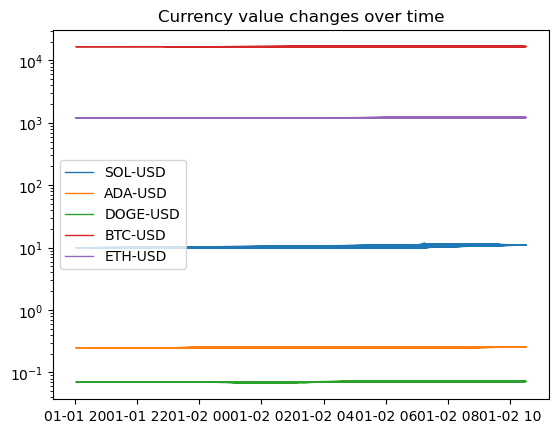

In [32]:
fig, ax = plt.subplots()
for line in plot_data:
    plt.plot(line["time"], line["price"], label = line["product_id"], linewidth = 1)
ax.set_yscale("log")
plt.title("Currency value changes over time")
plt.legend()
plt.show()

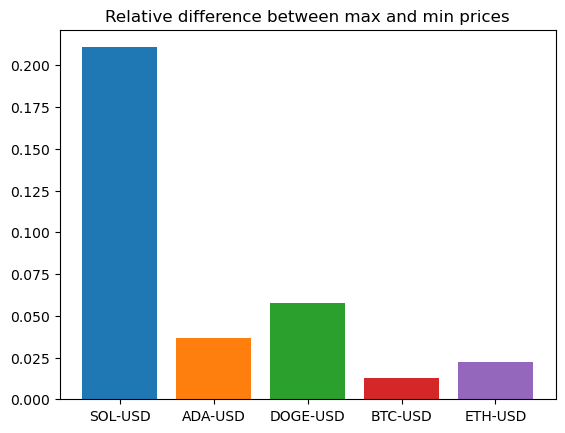

In [31]:
fig, ax = plt.subplots()
for line in plot_data:
    plt.bar(line["product_id"], (max(line["price"]) - min(line["price"])) / min(line["price"]))
plt.title("Relative difference between max and min prices")
plt.show()

## Crypto batch

In [38]:
df2 = spark.read.option("header", "true").csv("historical_crypto").distinct()

In [39]:
df2.printSchema()

root
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- cryptocurrency: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)



In [41]:
df2.count()

25848

In [48]:
data2 = df2.select("cryptocurrency", df2.date.cast(t.TimestampType()), df2.price.cast(t.DoubleType())).collect()
data2

[Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 10, 4, 5, 6, 35), price=19600.97252818627),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 10, 13, 9, 8, 16), price=19013.98771232447),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 10, 19, 14, 1, 14), price=19099.33660469521),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 10, 28, 19, 0, 48), price=20637.650614984206),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 11, 9, 8, 1, 30), price=18454.204862720144),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 11, 11, 10, 0, 13), price=17389.639938322805),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 11, 14, 14, 1, 46), price=16988.28378838569),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 11, 20, 14, 0, 12), price=16578.52534114607),
 Row(cryptocurrency='bitcoin', date=datetime.datetime(2022, 11, 25, 17, 1, 32), price=16477.197338150316),
 Row(cryptocurrency='bitcoin', date=datetime.da

In [51]:
product_id = [row.cryptocurrency for row in data2]
plot_data = []
for product in set(product_id):
    plot_data.append({
        "cryptocurrency": product,
        "time": [row.date for row in data2 if row.cryptocurrency == product],
        "price": [row.price for row in data2 if row.cryptocurrency == product]
    })
plot_data

[{'cryptocurrency': 'bitcoin',
  'time': [datetime.datetime(2022, 10, 4, 5, 6, 35),
   datetime.datetime(2022, 10, 13, 9, 8, 16),
   datetime.datetime(2022, 10, 19, 14, 1, 14),
   datetime.datetime(2022, 10, 28, 19, 0, 48),
   datetime.datetime(2022, 11, 9, 8, 1, 30),
   datetime.datetime(2022, 11, 11, 10, 0, 13),
   datetime.datetime(2022, 11, 14, 14, 1, 46),
   datetime.datetime(2022, 11, 20, 14, 0, 12),
   datetime.datetime(2022, 11, 25, 17, 1, 32),
   datetime.datetime(2022, 11, 28, 17, 1, 16),
   datetime.datetime(2022, 12, 6, 6, 0, 44),
   datetime.datetime(2022, 12, 13, 19, 0, 6),
   datetime.datetime(2022, 12, 27, 1, 1, 8),
   datetime.datetime(2022, 10, 27, 8, 0, 22),
   datetime.datetime(2022, 10, 27, 17, 2, 15),
   datetime.datetime(2022, 11, 4, 2, 1, 4),
   datetime.datetime(2022, 11, 9, 3, 0, 46),
   datetime.datetime(2022, 11, 22, 16, 1, 20),
   datetime.datetime(2022, 12, 10, 5, 1, 55),
   datetime.datetime(2022, 12, 25, 22, 0, 25),
   datetime.datetime(2022, 12, 27, 12,

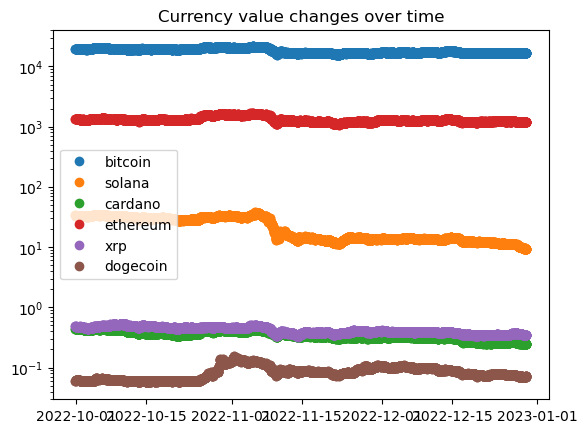

In [54]:
fig, ax = plt.subplots()
for line in plot_data:
    plt.plot_date(line["time"], line["price"], label = line["cryptocurrency"], linewidth = 1)
ax.set_yscale("log")
plt.title("Currency value changes over time")
plt.legend()
plt.show()

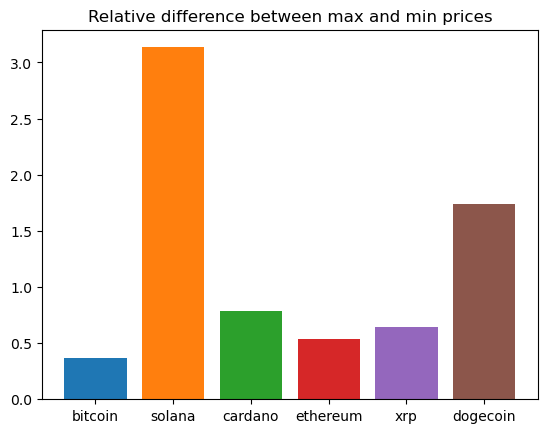

In [56]:
fig, ax = plt.subplots()
for line in plot_data:
    plt.bar(line["cryptocurrency"], (max(line["price"]) - min(line["price"])) / min(line["price"]))
plt.title("Relative difference between max and min prices")
plt.show()